In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow import keras
import os
from sklearn import model_selection
from sklearn import utils
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score
from scipy import ndimage
from gc import collect
import matplotlib.pyplot as plt
from collections import Counter
from seaborn import heatmap

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
def get_labels(label_file):
    """lê a tabela com as informações dos pacientes e retorna uma matriz com o ID e as labels"""
    labels = pd.read_csv(label_file)
    cancer_labels = dict()

    for p in labels.index:
        cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

    return cancer_labels

In [3]:
labels = get_labels('/kaggle/input/labelsssss/labels.csv')
numbers_per_class = [0, 0, 0, 0]
for i in labels:
    numbers_per_class[np.argmax(labels[i])] += 1

proportion_per_class = [round(number_of_class/sum(numbers_per_class), 2) for number_of_class in numbers_per_class]
proportion_per_class

[0.35, 0.25, 0.23, 0.17]

In [4]:
path = '/kaggle/input/192x256xdepth/'
dirs = os.listdir(path)

X = [path + i for i in os.listdir(path)]
y = [np.argmax(labels[(path+i)[-14:-4]]) for i in os.listdir(path)]

In [5]:
def balancing_batch(X, y, max_value):
    numbers_per_class = sorted(Counter(y).items())
    
    if len(numbers_per_class) == 1:
        return X[0:1], y[0:1] #return only the first image because the batch has only one class
    
    if numbers_per_class[0][1] > numbers_per_class[1][1]:
        max_per_class = numbers_per_class[1][1]
    else:
        max_per_class = numbers_per_class[0][1]
    
    if max_per_class > max_value//2:
        max_per_class = max_value//2
        
    X, y = utils.shuffle(X, y)
    new_X, new_y = [], []
    counter_class_zero = 0
    counter_class_one = 0
    for test_x, test_y in zip(X, y):
        if test_y == 0 and counter_class_zero < max_per_class//2:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_zero += 1
        elif test_y == 1 and counter_class_one < max_per_class//2:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_one += 1
    
    return np.array(new_X, dtype='float16'), np.array(new_y, dtype='float16')

In [6]:
def separate_slices(img):
    'function to separate 2d images of 3d original image'
    slices = []

    for i in range(img.shape[-2]):
        slices.append(np.array(img[:, :, i]))

    slices.append(np.mean(img, axis=-2)) #including mean of slices
        
    return slices

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y,random_state=42, train_size=0.8)

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, objective, list_IDs, labels_dir, batch_size, sub_batch_size, dim_img, training, shuffle=True):
        self.objective = objective # list representing one hot encoding for choice label ([1, 0, 0, 0] for normal, [0, 0, 0, 1] for cancer ..)
        self.list_IDs = list_IDs # array of strings with original images name with directory
        self.labels = self.__get_labels(labels_dir) #dict with labels of all images
        self.batch_size = batch_size #3d-images per batch
        self.sub_batch_size = sub_batch_size #quantity of sub-images per batch will be choose to train
        self.dim_img = dim_img # tuple with width and height of image like (192, 256)
        self.training = training # true if generator is for training, false if generator is for validation
        self.shuffle = shuffle # true or false to shuffle data after any epochs
        self.on_epoch_end() # call of the function
        
    
    def __get_labels(self, label_file):
        'take the dict with labels of images'
        labels = pd.read_csv(label_file)
        cancer_labels = dict()

        for p in labels.index:
            cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

        return cancer_labels
    
    def __data_augmentation(self, x):
        'generate variations of images'
        new_images = []
        x = x.astype('float16')
        new_images.append(x)
        
        x = cv2.flip(x.astype('float32'), 1).astype('float16')
            
        new_images.append(np.expand_dims(x, -1))

        return utils.shuffle(new_images)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    

    def __getitem__(self, index):        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        if self.training:
            X, y = balancing_batch(X, y, self.sub_batch_size)
            return np.array(X[0:self.sub_batch_size], dtype='float16'), np.array(y[0:self.sub_batch_size], dtype='uint8')
        
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            prev_len_X = len(X)
            full_image = np.load(ID)
            new_images = separate_slices(full_image)
            if self.training:
                for img in new_images:
                    X += self.__data_augmentation(img)
            else:
                X = np.array(new_images, dtype='float16')
            
            #adding new data labels for y array
            for _ in range(len(X) - prev_len_X):
                if self.labels[ID[-14:-4]] == self.objective: #'-14:-4 represent a part of string with name of original image that slices was taken'
                    y.append(1)
                else:
                    y.append(0)
                    
        X, y = utils.shuffle(X, y)
        return X, y

In [9]:
class InceptionModule_a(keras.layers.Layer):
    def __init__(self, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get('relu')
        
        self.conv_a1    = keras.layers.Conv2D(64, kernel_size=(1,1), padding='same', strides=1)
        self.bn_a1      = keras.layers.BatchNormalization()
        self.conv_a2    = keras.layers.Conv2D(96, kernel_size=(3,3), padding='same', strides=1)
        self.bn_a2      = keras.layers.BatchNormalization()
        self.conv_a3    = keras.layers.Conv2D(96, kernel_size=(3,3), padding='same', strides=1)
        self.bn_a3      = keras.layers.BatchNormalization()
        
        self.conv_b1    = keras.layers.Conv2D(48, kernel_size=(1, 1), padding='same', strides=1)
        self.conv_b2    = keras.layers.Conv2D(48, kernel_size=(3, 3), padding='same', strides=1)
        self.bn_b1       = keras.layers.BatchNormalization()
        
        self.maxpool_c  = keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', strides=1)
        self.conv_c1    = keras.layers.Conv2D(32, kernel_size=(1, 1), padding='same', strides=1)
        self.bn_c1      = keras.layers.BatchNormalization()
        
        self.conv_d1    = keras.layers.Conv2D(64, kernel_size=(1, 1), padding='same', strides=1)
        self.bn_d       = keras.layers.BatchNormalization()
        
    def call(self, x):
        out1 = self.conv_a1(x)
        out1 = self.bn_a1(out1)
        out1 = self.conv_a2(out1)
        out1 = self.bn_a2(out1)
        out1 = self.conv_a3(out1)
        out1 = self.bn_a3(out1)
        out1 = self.activation(out1)
        
        out2 = self.conv_b1(x)
        out2 = self.conv_b2(out2)
        out2 = self.bn_b1(out2)
        out2 = self.activation(out2)
        
        out3 = self.maxpool_c(x)
        out3 = self.conv_c1(out3)
        out3 = self.bn_c1(out3)
        out3 = self.activation(out3)
        
        out4 = self.conv_d1(x)
        out4 = self.bn_d(out4)
        out4 = self.activation(out4)
        
        return tf.concat([out1, out2, out3, out4], axis=3)
    
class InceptionReduction_a(keras.layers.Layer):
    def __init__(self, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get('relu')
        
        self.maxpool_a  = keras.layers.MaxPooling2D(pool_size=(2), padding='same')
        
        self.conv_b1 = keras.layers.Conv2D(384, kernel_size=(2, 4), padding='same', strides=2)
        self.bn_b1    = keras.layers.BatchNormalization()
        
        self.conv_c1 = keras.layers.Conv2D(64, kernel_size=(1,1), padding='same')
        self.conv_c2 = keras.layers.Conv2D(96, kernel_size=(2,4), padding='same')
        self.bn_c1   = keras.layers.BatchNormalization()
        self.conv_c3 = keras.layers.Conv2D(96, kernel_size=(2,4), padding='same', strides=2)
        self.bn_c2   = keras.layers.BatchNormalization()
        
    def call(self, x):
        out1 = self.maxpool_a(x)
        out1 = self.activation(out1)
        
        out2 = self.conv_b1(x)
        out2 = self.bn_b1(out2)
        out2 = self.activation(out2)
        
        out3 = self.conv_c1(x)
        out3 = self.conv_c2(out3)
        out3 = self.bn_c1(out3)
        out3 = self.conv_c3(out3)
        out3 = self.bn_c2(out3)
        out3 = self.activation(out3)
        
        return tf.concat([out1, out2, out3], axis=3)

class InceptionModule_b(keras.layers.Layer):
    def __init__(self, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get('relu')
        
        self.conv_a1   = keras.layers.Conv2D(128, kernel_size=(1,1), padding='same', strides=1)
        self.conv_a2   = keras.layers.Conv2D(128, kernel_size=(1,7), padding='same', strides=1)
        self.bn_a1     = keras.layers.BatchNormalization()
        self.conv_a3   = keras.layers.Conv2D(128, kernel_size=(7,1), padding='same', strides=1)
        self.bn_a2     = keras.layers.BatchNormalization()
        self.conv_a4   = keras.layers.Conv2D(128, kernel_size=(1,7), padding='same', strides=1)
        self.bn_a3     = keras.layers.BatchNormalization()
        self.conv_a5   = keras.layers.Conv2D(192, kernel_size=(7,1), padding='same', strides=1)
        self.bn_a4     = keras.layers.BatchNormalization()
        
        self.conv_b1   = keras.layers.Conv2D(128, kernel_size=(1, 1), padding='same', strides=1)
        self.conv_b2   = keras.layers.Conv2D(128, kernel_size=(7, 1), padding='same', strides=1)
        self.bn_b1     = keras.layers.BatchNormalization()
        self.conv_b3   = keras.layers.Conv2D(192, kernel_size=(1, 7), padding='same', strides=1)
        self.bn_b2     = keras.layers.BatchNormalization()
        
        self.maxpool_c = keras.layers.MaxPooling2D(pool_size=(2), padding='same', strides=1)
        self.conv_c1   = keras.layers.Conv2D(192, kernel_size=(1, 1), padding='same', strides=1)
        self.bn_c1     = keras.layers.BatchNormalization()
        
        self.conv_d1    = keras.layers.Conv2D(192, kernel_size=(1, 1), padding='same', strides=1)
        self.bn_d1      = keras.layers.BatchNormalization()
        
    def call(self, x):
        out1 = self.conv_a1(x)
        out1 = self.conv_a2(out1)
        out1 = self.bn_a1(out1)
        out1 = self.conv_a3(out1)
        out1 = self.bn_a2(out1)
        out1 = self.conv_a4(out1)
        out1 = self.bn_a3(out1)
        out1 = self.conv_a5(out1)
        out1 = self.bn_a4(out1)
        out1 = self.activation(out1)
        
        out2 = self.conv_b1(x)
        out2 = self.conv_b2(out2)
        out2 = self.bn_b1(out2)
        out2 = self.conv_b3(out2)
        out2 = self.bn_b2(out2)
        out2 = self.activation(out2)
        
        out3 = self.maxpool_c(x)
        out3 = self.conv_c1(out3)
        out3 = self.bn_c1(out3)
        out4 = self.activation(out3)
        
        out4 = self.conv_d1(x)
        out4 = self.bn_d1(out4)
        out4 = self.activation(out4)
        
        return tf.concat([out1, out2, out3, out4], axis=3)
    
class InceptionReduction_b(keras.layers.Layer):
    def __init__(self, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get('relu')
        
        self.maxpool_a  = keras.layers.MaxPooling2D(pool_size=(2), padding='same', strides=2)
        
        self.conv_b1 = keras.layers.Conv2D(192, kernel_size=(1,1), padding='same')
        self.conv_b2 = keras.layers.Conv2D(320, kernel_size=(2,4), padding='same', strides=2)
        self.bn_b    = keras.layers.BatchNormalization()
        
        self.conv_c1 = keras.layers.Conv2D(192, kernel_size=(1,1), padding='same')
        self.conv_c2 = keras.layers.Conv2D(192, kernel_size=(1,7), padding='same')
        self.bn_c1   = keras.layers.BatchNormalization()
        self.conv_c3 = keras.layers.Conv2D(192, kernel_size=(7,1), padding='same')
        self.bn_c2   = keras.layers.BatchNormalization()
        self.conv_c4 = keras.layers.Conv2D(192, kernel_size=(2, 4), padding='same', strides=2)
        self.bn_c3   = keras.layers.BatchNormalization()
        
    def call(self, x):
        out1 = self.maxpool_a(x)
        out1 = self.activation(out1)
        
        out2 = self.conv_b1(x)
        out2 = self.conv_b2(out2)
        out2 = self.bn_b(out2)
        out2 = self.activation(out2)
        
        out3 = self.conv_c1(x)
        out3 = self.conv_c2(out3)
        out3 = self.bn_c1(out3)
        out3 = self.conv_c3(out3)
        out3 = self.bn_c2(out3)
        out3 = self.conv_c4(out3)
        out3 = self.bn_c3(out3)
        out3 = self.activation(out3)
        
        return tf.concat([out1, out2, out3], axis=3)
    
class InceptionModule_c(keras.layers.Layer):
    def __init__(self, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get('relu')
        
        self.conv_a1   = keras.layers.Conv2D(192, kernel_size=(1,1), padding='same')
        self.conv_a2   = keras.layers.Conv2D(192, kernel_size=(3,3), padding='same')
        self.bn_a1     = keras.layers.BatchNormalization()
        self.conv_a11  = keras.layers.Conv2D(192, kernel_size=(1,3), padding='same', strides=2)
        self.bn_a11    = keras.layers.BatchNormalization()
        self.conv_a12  = keras.layers.Conv2D(192, kernel_size=(3,1), padding='same',strides=2)
        self.bn_a12    = keras.layers.BatchNormalization()
        
        self.conv_a1   = keras.layers.Conv2D(192, kernel_size=(1,1), padding='same')
        self.bn_a1     = keras.layers.BatchNormalization()
        self.conv_a11  = keras.layers.Conv2D(192, kernel_size=(1,3), padding='same', strides=2)
        self.bn_a11    = keras.layers.BatchNormalization()
        self.conv_a12  = keras.layers.Conv2D(192, kernel_size=(3,1), padding='same', strides=2)
        self.bn_a12    = keras.layers.BatchNormalization()
        
        self.maxpool_c = keras.layers.MaxPooling2D(pool_size=(2), padding='same')
        self.conv_c1   = keras.layers.Conv2D(192, kernel_size=(1, 1), padding='same')
        self.bn_c      = keras.layers.BatchNormalization()
        
        self.conv_d    = keras.layers.Conv2D(384, kernel_size=(1, 1), padding='same', strides=2)
        self.bn_d      = keras.layers.BatchNormalization()
        
    def call(self, x):
        out1  = self.conv_a1(x)
        out1  = self.conv_a2(out1)
        out1  = self.bn_a1(out1)
        out11 = self.conv_a11(out1)
        out11 = self.bn_a11(out11)
        out11 = self.activation(out11)
        out12 = self.conv_a12(out1)
        out12 = self.bn_a12(out12)
        out11 = self.activation(out12)
        
        out2 = self.conv_a1(x)
        out2 = self.bn_a1(out2)
        out21 = self.conv_a11(out2)
        out21 = self.bn_a11(out21)
        out21 = self.activation(out21)
        out22 = self.conv_a12(out2)
        out22 = self.bn_a12(out22)
        out22 = self.activation(out22)
        
        out3 = self.maxpool_c(x)
        out3 = self.conv_c1(out3)
        out3 = self.bn_c(out3)
        out3 = self.activation(out3)
        
        out4 = self.conv_d(x)
        out4 = self.bn_d(out4)
        out4 = self.activation(out4)
        
        return tf.concat([out11, out12, out21, out22, out3, out4], axis=3)

def get_inception_v3():
    Inception_v3 = keras.Sequential()
    Inception_v3.add(keras.layers.Conv2D(filters=32, kernel_size=(4,2), padding='valid', strides=2, input_shape=(192, 256, 1)))
    Inception_v3.add(keras.layers.BatchNormalization())
    Inception_v3.add(keras.layers.Conv2D(filters=32, kernel_size=(4,2), padding='valid', strides=1))
    Inception_v3.add(keras.layers.BatchNormalization())
    Inception_v3.add(keras.layers.Conv2D(filters=64, kernel_size=(4,2), padding='same', strides=1))
    Inception_v3.add(keras.layers.BatchNormalization())
    Inception_v3.add(keras.layers.MaxPooling2D(2))
    Inception_v3.add(keras.layers.Conv2D(filters=80, kernel_size=(4,2), padding='valid', strides=1))
    Inception_v3.add(keras.layers.BatchNormalization())
    Inception_v3.add(keras.layers.Conv2D(filters=192, kernel_size=(4,2), padding='valid', strides=2))
    Inception_v3.add(keras.layers.BatchNormalization())
    Inception_v3.add(InceptionModule_a())
    Inception_v3.add(InceptionModule_a())
    Inception_v3.add(InceptionModule_a())
    Inception_v3.add(InceptionReduction_a())
    Inception_v3.add(InceptionModule_b())
    Inception_v3.add(InceptionModule_b())
    Inception_v3.add(InceptionModule_b())
    Inception_v3.add(InceptionModule_b())
    Inception_v3.add(InceptionModule_b())
    Inception_v3.add(InceptionReduction_b())
    Inception_v3.add(InceptionModule_c())
    Inception_v3.add(InceptionModule_c())
    Inception_v3.add(keras.layers.GlobalAveragePooling2D())
    Inception_v3.add(keras.layers.Dense(2048, activation='relu'))
    Inception_v3.add(keras.layers.Dense(1, activation='sigmoid'))
    
    return Inception_v3

In [12]:
inception = get_inception_v3()
inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 95, 128, 32)       288       
                                                                 
 batch_normalization (BatchN  (None, 95, 128, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 127, 32)       8224      
                                                                 
 batch_normalization_1 (Batc  (None, 92, 127, 32)      128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 127, 64)       16448     
                                                                 
 batch_normalization_2 (Batc  (None, 92, 127, 64)      2

**NORMAL**

In [11]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [12]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[1, 0, 0, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        inception = get_inception_v3()
        inception.compile(loss='binary_crossentropy', 
                         optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                         metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                                  keras.metrics.BinaryAccuracy(name='accuracy'),
                                  keras.metrics.Precision(name='precision'),
                                  keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(inception.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 187s 3s/step - loss: 0.7893 - AUC_1: 0.5779 - accuracy: 0.5626 - precision: 0.5656 - recall: 0.5382 - val_loss: 0.6851 - val_AUC_1: 0.5000 - val_accuracy: 0.7081 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 74s 3s/step - loss: 0.6451 - AUC_1: 0.7139 - accuracy: 0.6792 - precision: 0.7386 - recall: 0.5539 - val_loss: 0.6804 - val_AUC_1: 0.5000 - val_accuracy: 0.7081 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 81s 3s/step - loss: 0.5478 - AUC_1: 0.8018 - accuracy: 0.7302 - precision: 0.7350 - recall: 0.7197 - val_loss: 0.6416 - val_AUC_1: 0.5018 - val_accuracy: 0.7081 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 72s 2s/step - loss: 0.4828 - AUC_1: 0.8514 - accuracy: 0.7665 - precision: 0.7838 - rec

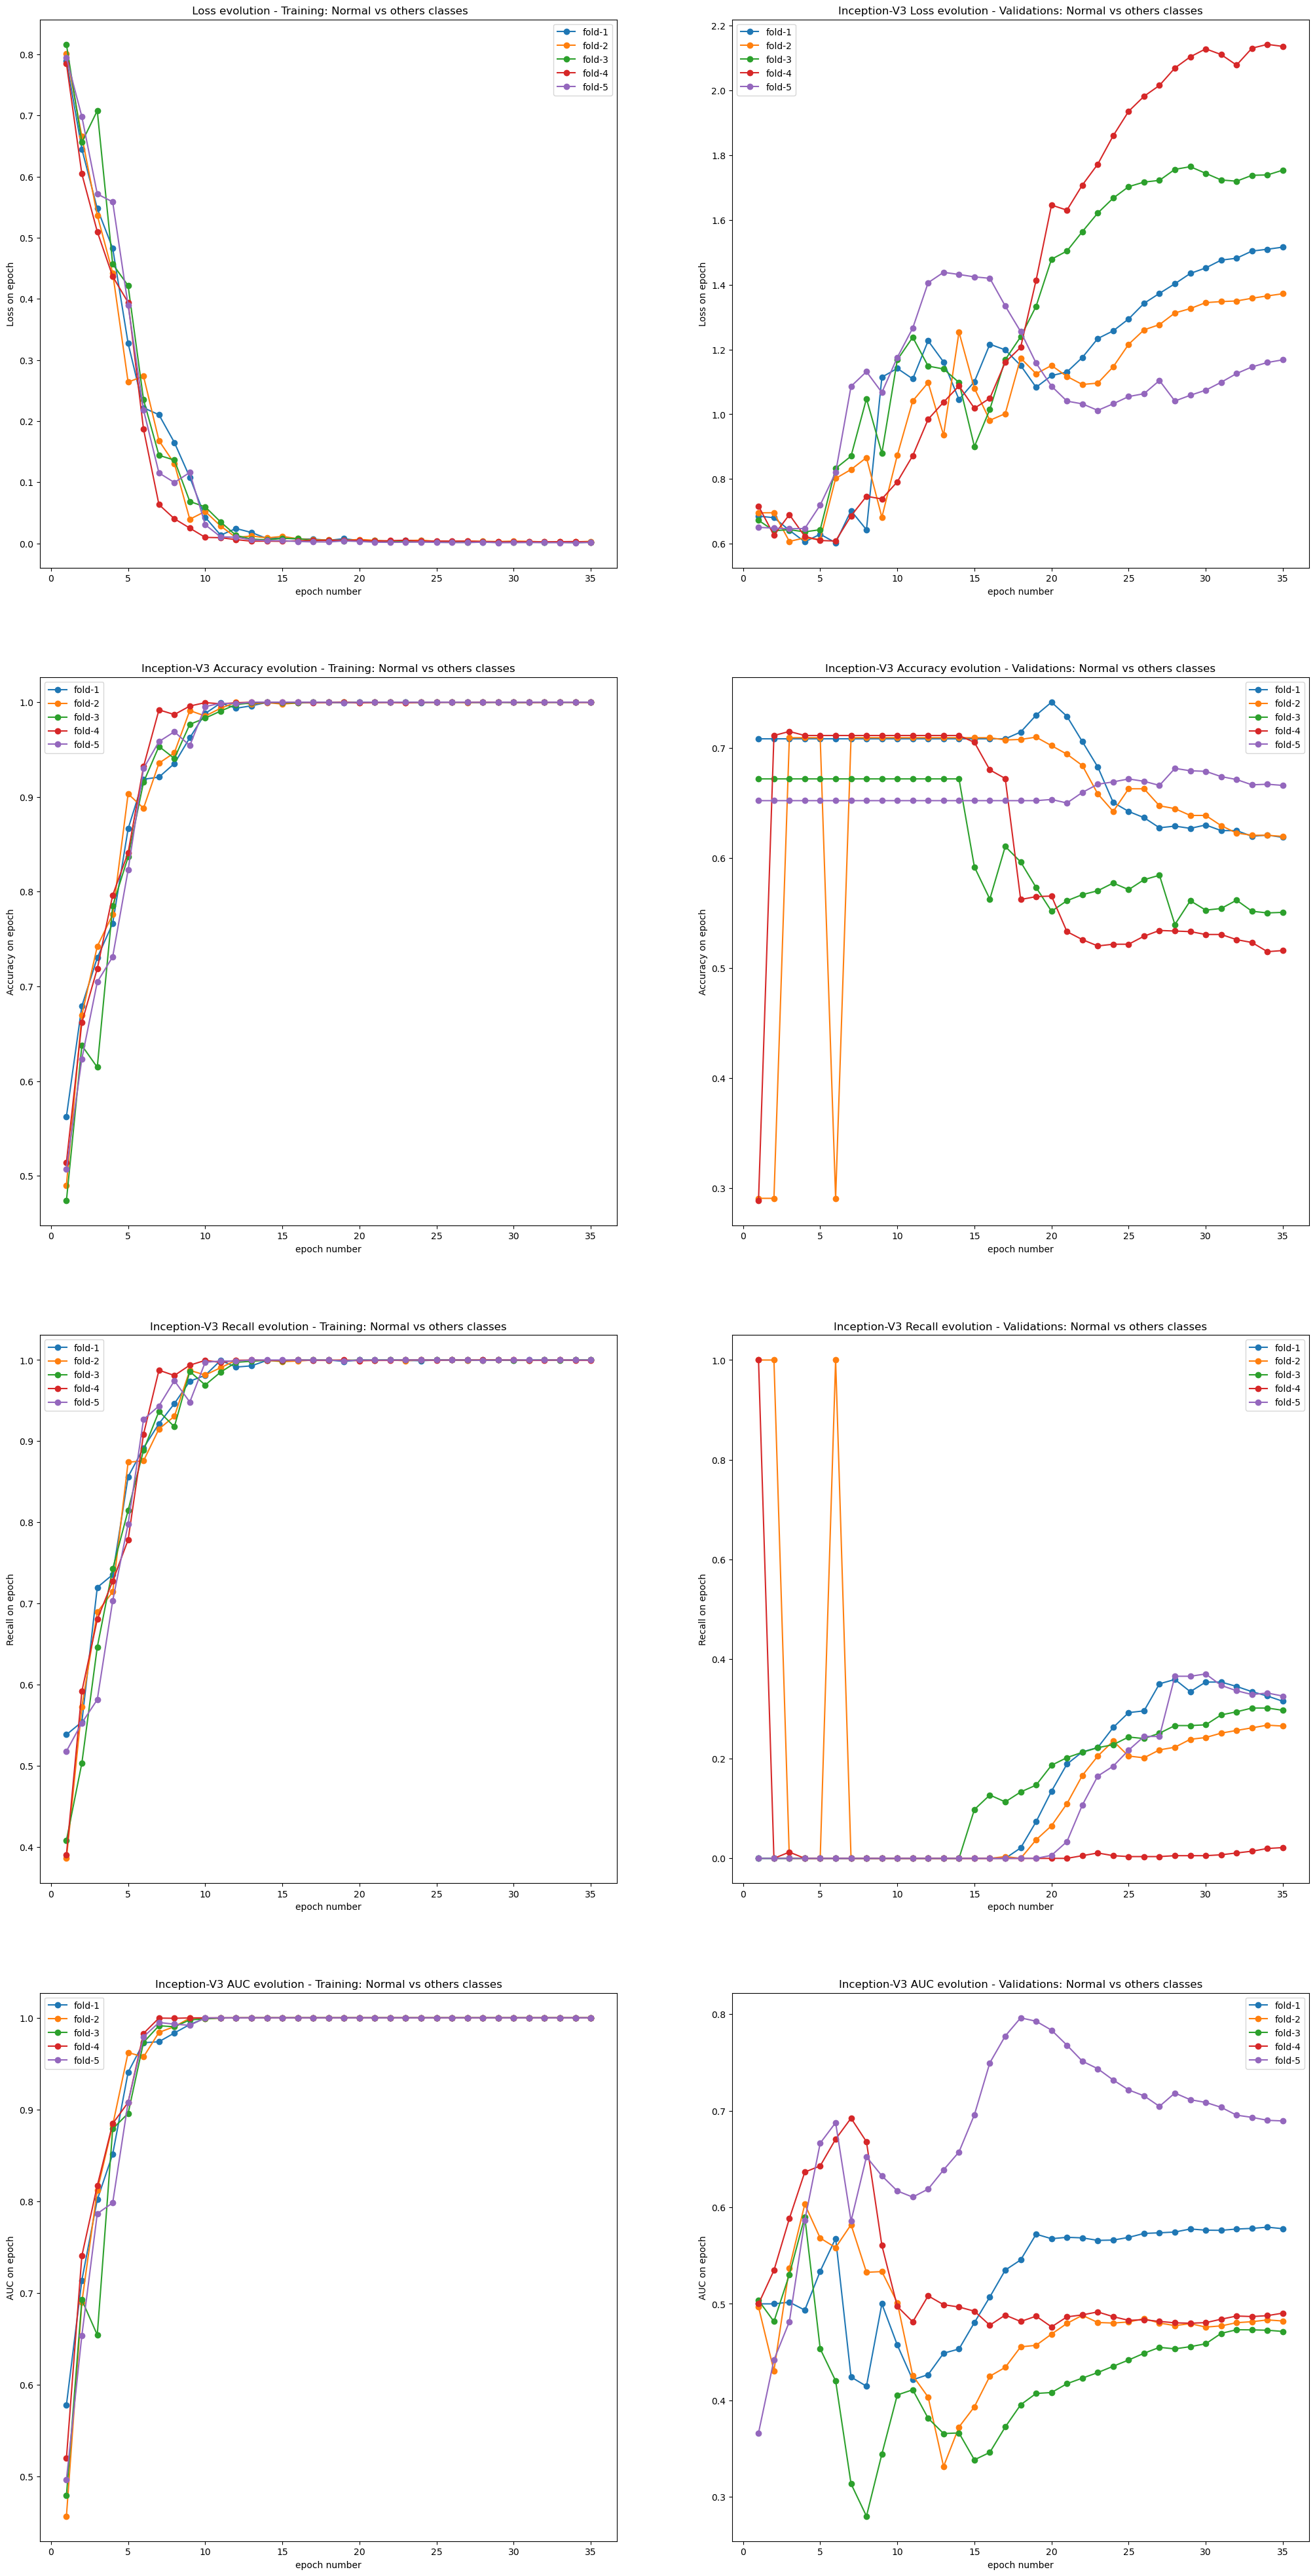

In [13]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title(' Loss evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('Inception-V3 Loss evolution - Validations: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('Inception-V3 Accuracy evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('Inception-V3 Accuracy evolution - Validations: Normal vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('Inception-V3 Recall evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('Inception-V3 Recall evolution - Validations: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('Inception-V3 AUC evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('Inception-V3 AUC evolution - Validations: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [14]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")


Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5794306397438049
Best Accuracy in validation: 0.7413088083267212
Best Precision in validation: 1.0
Best Recall in validation: 0.3590192496776581


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6031368374824524
Best Accuracy in validation: 0.709577739238739
Best Precision in validation: 0.5121951103210449
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5902066230773926
Best Accuracy in validation: 0.6716943383216858
Best Precision in validation: 0.32669323682785034
Best

**ACTIONABLE**

In [11]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [ ]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 1, 0, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 1, 0, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    inception = get_inception_v3()
    
    inception.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(inception.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

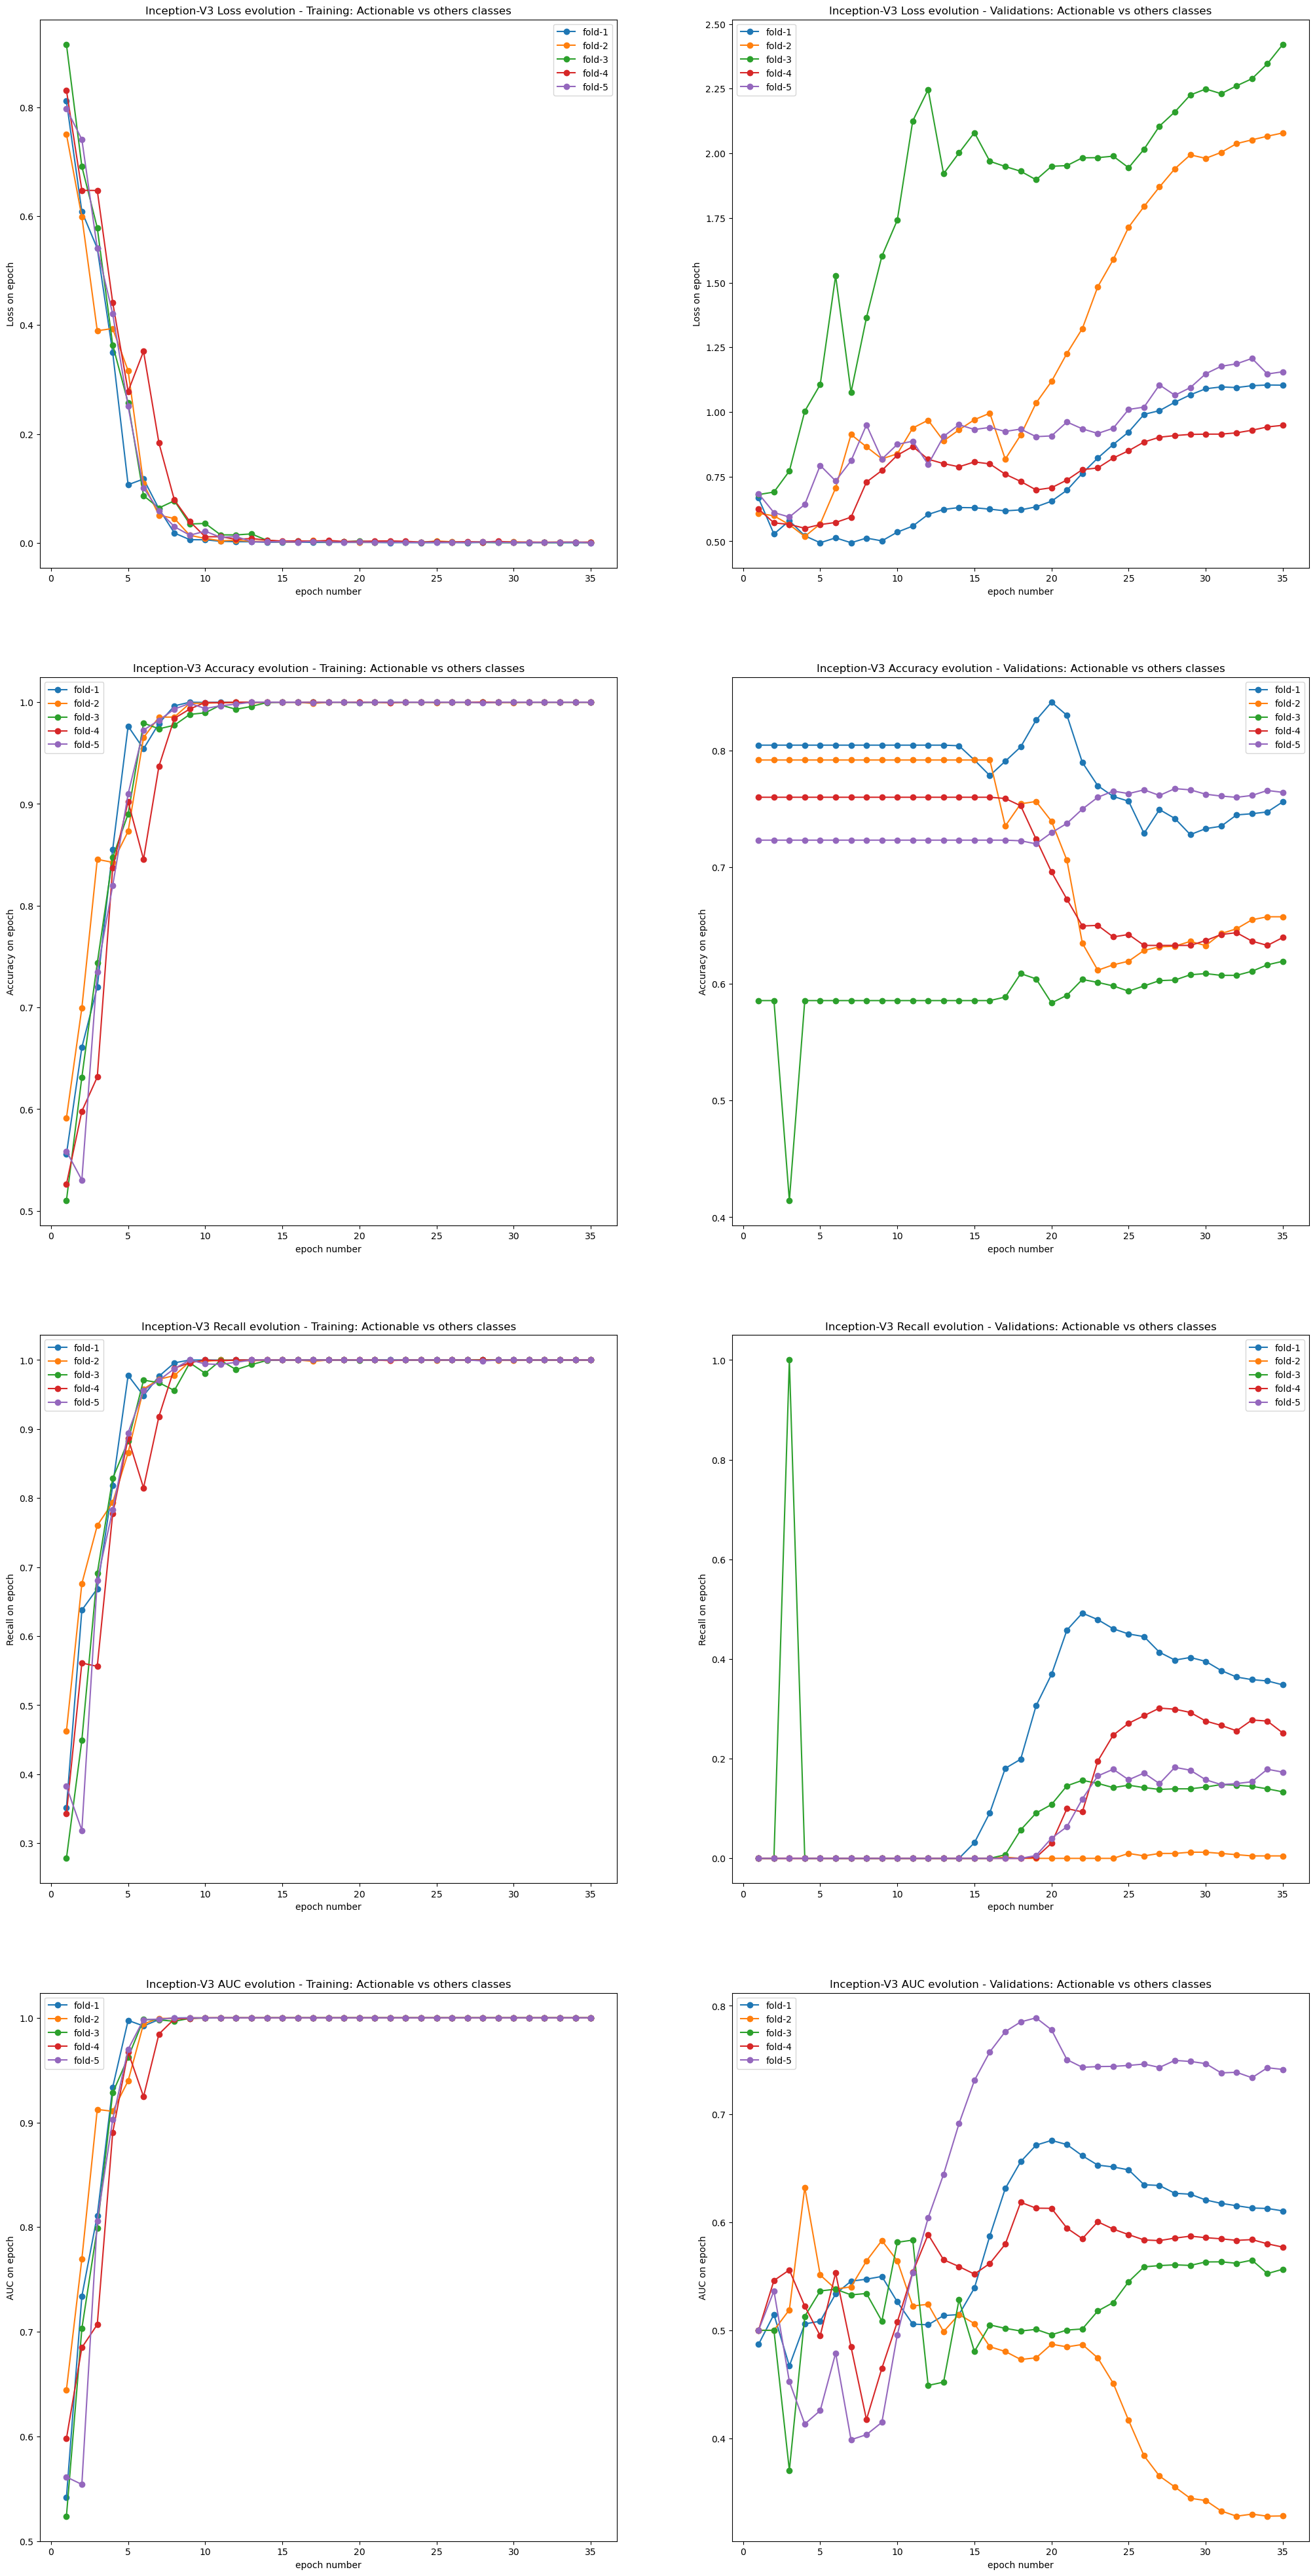

In [14]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('Inception-V3 Loss evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('Inception-V3 Loss evolution - Validations: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('Inception-V3 Accuracy evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('Inception-V3 Accuracy evolution - Validations: Actionable vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('Inception-V3 Recall evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('Inception-V3 Recall evolution - Validations: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('Inception-V3 AUC evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('Inception-V3 AUC evolution - Validations: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [15]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")


Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.675550639629364
Best Accuracy in validation: 0.8415132761001587
Best Precision in validation: 0.6714285612106323
Best Recall in validation: 0.4921466112136841


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6321288347244263
Best Accuracy in validation: 0.7919670343399048
Best Precision in validation: 0.016025641933083534
Best Recall in validation: 0.012376237660646439


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.583403468132019
Best Accuracy in validation: 0.6194067597389221
Best P

**BENIGN**

In [12]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [13]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 0, 1, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 0, 1, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    inception = get_inception_v3()
    
    inception.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(inception.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 201s 4s/step - loss: 0.9061 - AUC_1: 0.5520 - accuracy: 0.5156 - precision: 0.5192 - recall: 0.3966 - val_loss: 0.6786 - val_AUC_1: 0.5000 - val_accuracy: 0.6053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 71s 2s/step - loss: 0.8635 - AUC_1: 0.5012 - accuracy: 0.5128 - precision: 0.5190 - recall: 0.3019 - val_loss: 0.6775 - val_AUC_1: 0.5000 - val_accuracy: 0.6053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 69s 2s/step - loss: 0.6546 - AUC_1: 0.6935 - accuracy: 0.6124 - precision: 0.6497 - recall: 0.4821 - val_loss: 0.6943 - val_AUC_1: 0.4824 - val_accuracy: 0.6053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 63s 2s/step - loss: 0.6179 - AUC_1: 0.7577 - accuracy: 0.6648 - precision: 0.7664 - rec

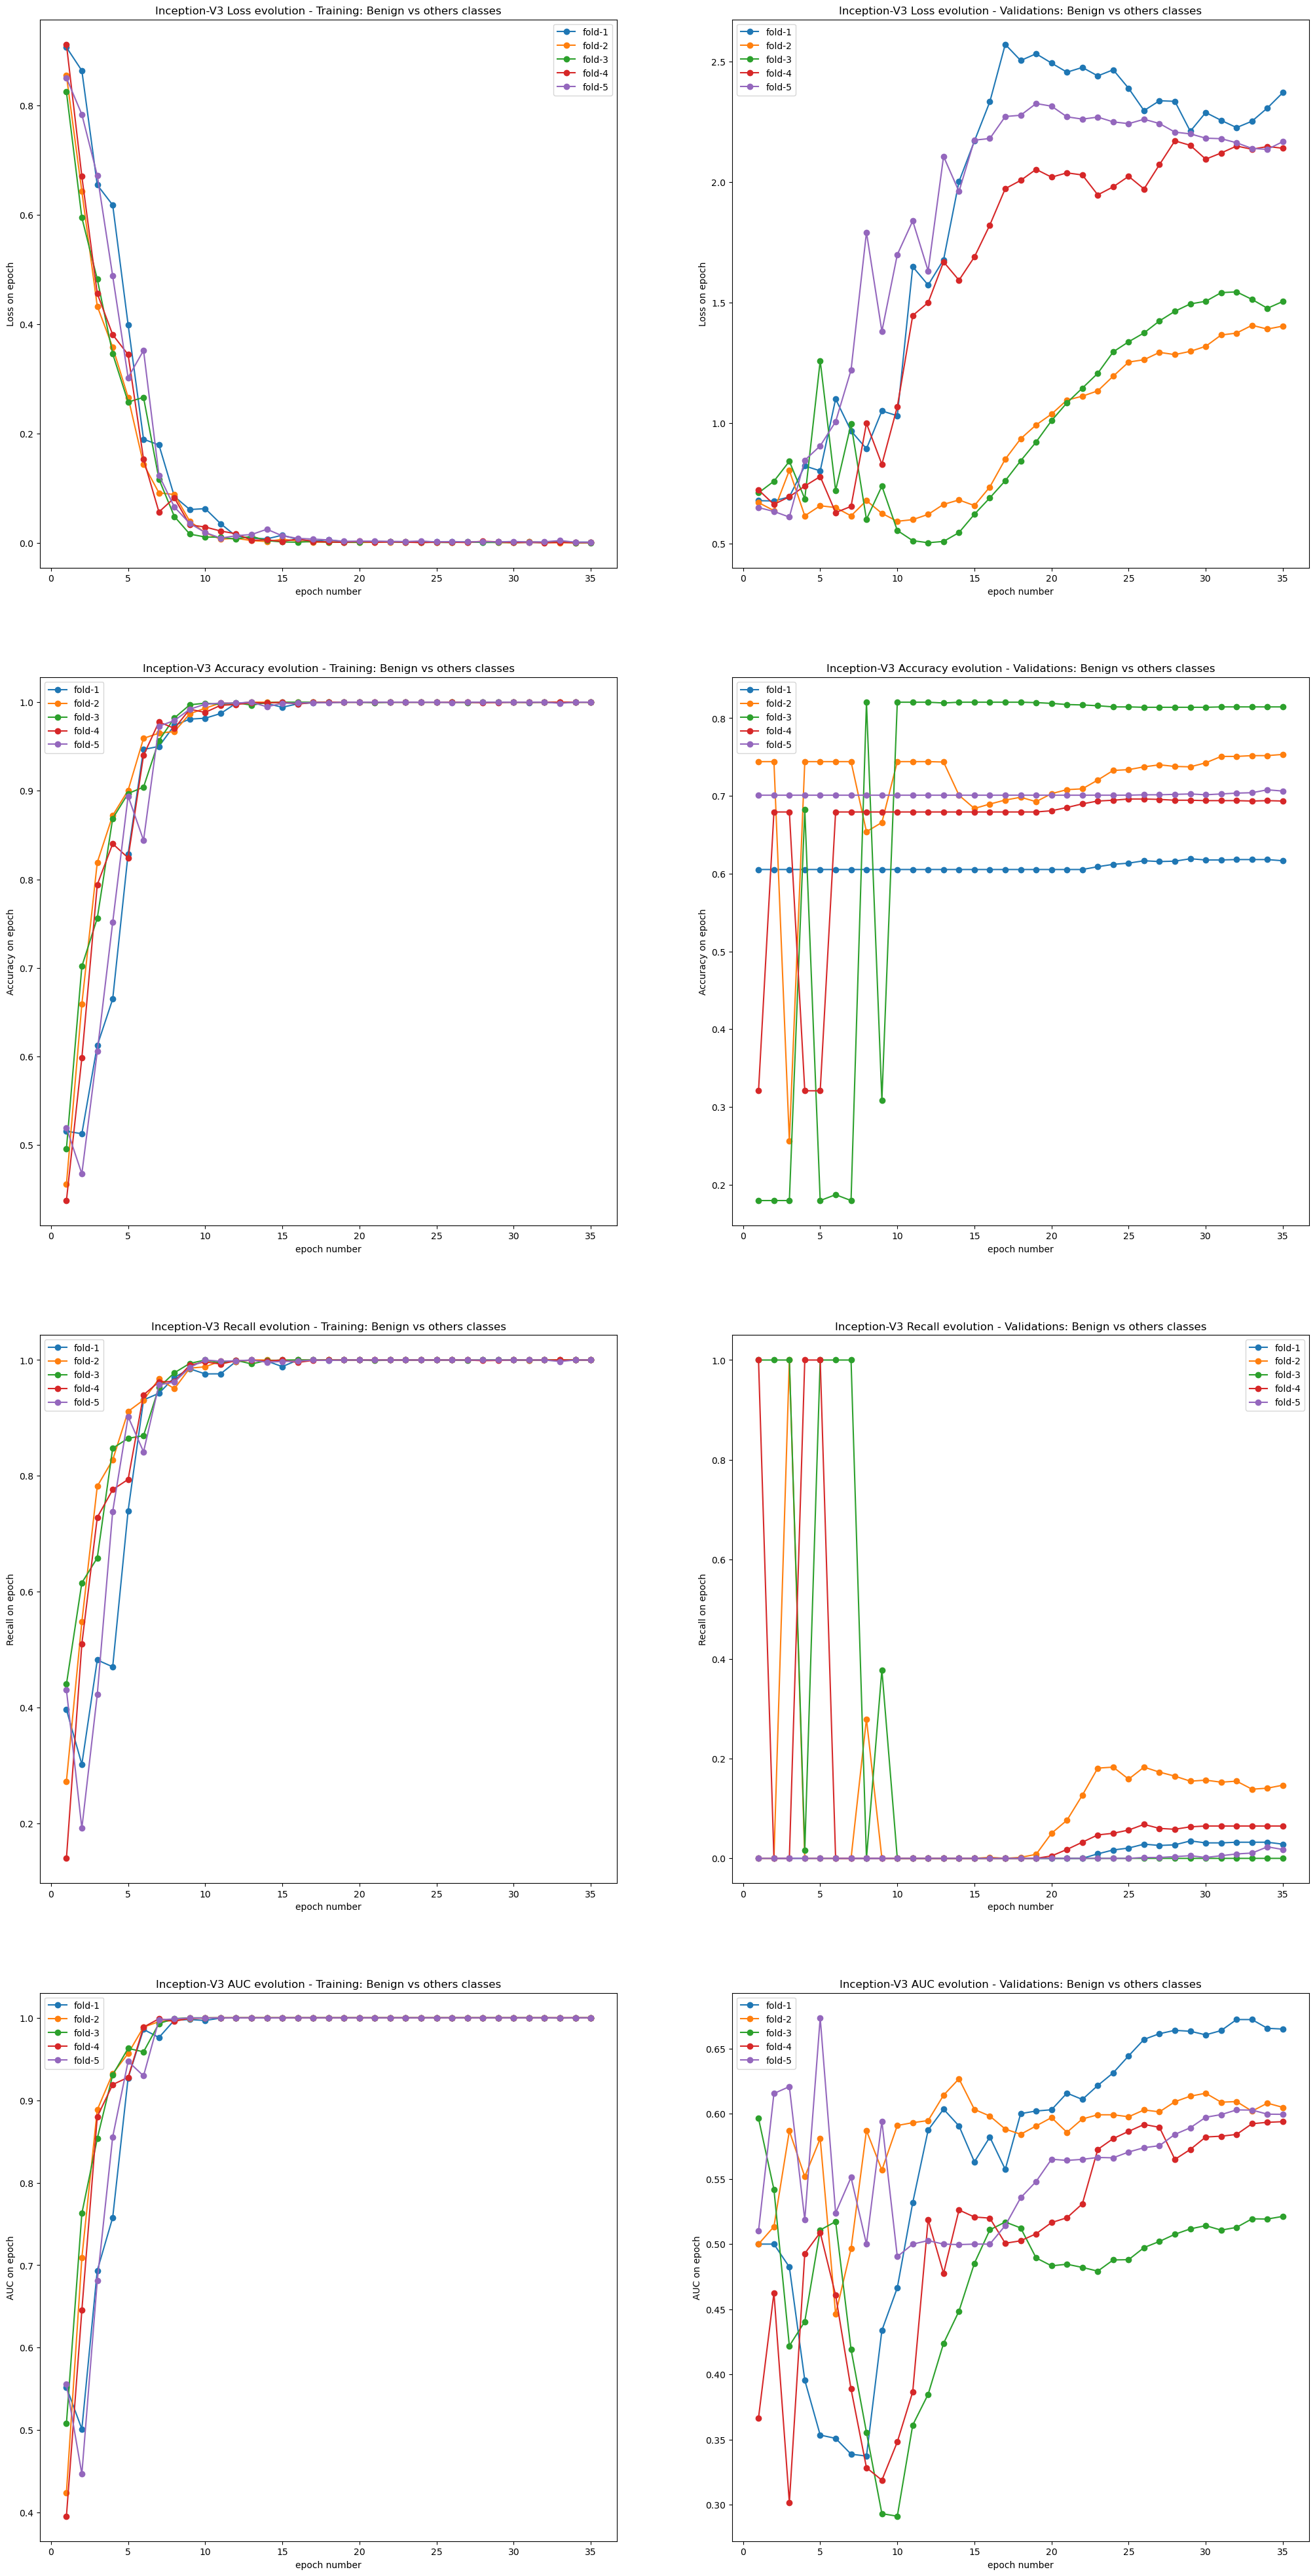

In [14]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('Inception-V3 Loss evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('Inception-V3 Loss evolution - Validations: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('Inception-V3 Accuracy evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('Inception-V3 Accuracy evolution - Validations: Benign vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('Inception-V3 Recall evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('Inception-V3 Recall evolution - Validations: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('Inception-V3 AUC evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('Inception-V3 AUC evolution - Validations: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [15]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6723694801330566
Best Accuracy in validation: 0.6191206574440002
Best Precision in validation: 1.0
Best Recall in validation: 0.03497409448027611


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6268858909606934
Best Accuracy in validation: 0.7533470392227173
Best Precision in validation: 0.5703125
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5965073108673096
Best Accuracy in validation: 0.8205128312110901
Best Precision in validation: 0

**CANCER**

In [11]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [12]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 0, 0, 1],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 0, 0, 1],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    inception = get_inception_v3()
    
    inception.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(inception.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 202s 4s/step - loss: 0.8858 - AUC_1: 0.5195 - accuracy: 0.4380 - precision: 0.3453 - recall: 0.1446 - val_loss: 0.6916 - val_AUC_1: 0.4714 - val_accuracy: 0.6544 - val_precision: 0.1197 - val_recall: 0.3030 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 68s 2s/step - loss: 0.6228 - AUC_1: 0.7510 - accuracy: 0.6862 - precision: 0.7550 - recall: 0.5456 - val_loss: 0.7008 - val_AUC_1: 0.4779 - val_accuracy: 0.1043 - val_precision: 0.0935 - val_recall: 0.7576 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 70s 2s/step - loss: 0.4559 - AUC_1: 0.8701 - accuracy: 0.7843 - precision: 0.8137 - recall: 0.7343 - val_loss: 0.5203 - val_AUC_1: 0.4951 - val_accuracy: 0.8819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 65s 2s/step - loss: 0.3975 - AUC_1: 0.9088 - accuracy: 0.8346 - precision: 0.8757 - recall: 0.7776 - va

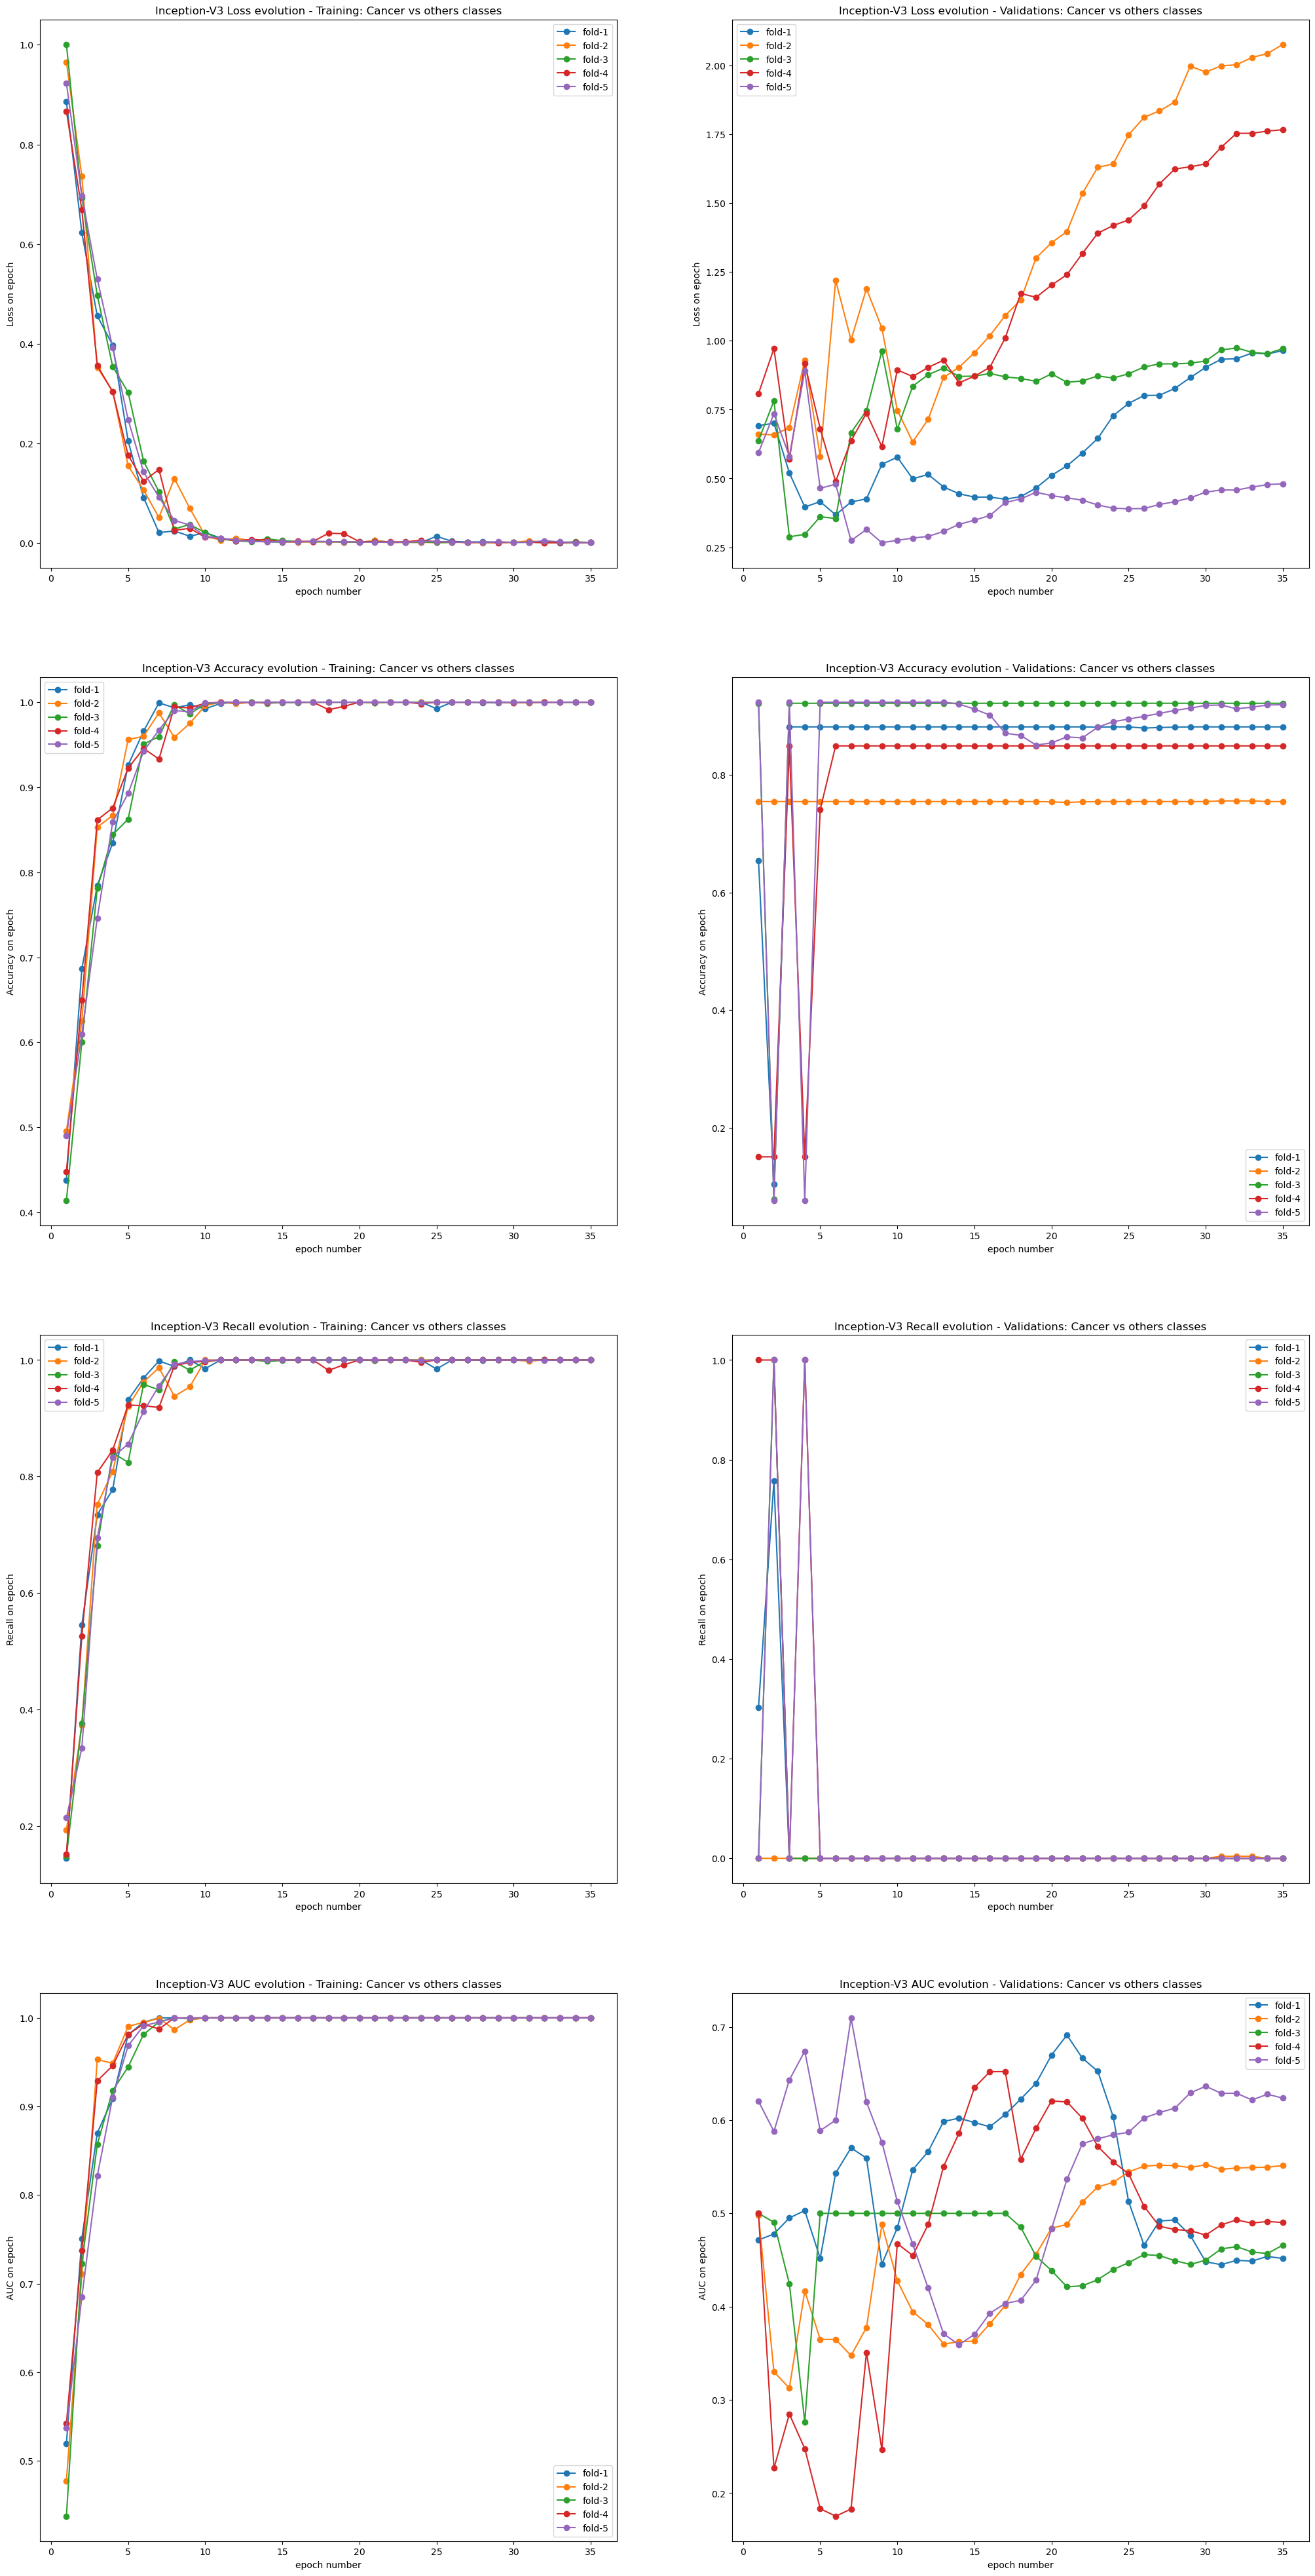

In [13]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('Inception-V3 Loss evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('Inception-V3 Loss evolution - Validations: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('Inception-V3 Accuracy evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('Inception-V3 Accuracy evolution - Validations: Cancer vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('Inception-V3 Recall evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('Inception-V3 Recall evolution - Validations: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('Inception-V3 AUC evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('Inception-V3 AUC evolution - Validations: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [14]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6912441253662109
Best Accuracy in validation: 0.8819018602371216
Best Precision in validation: 0.11965811997652054
Best Recall in validation: 0.7575757503509521


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5521979331970215
Best Accuracy in validation: 0.7559217214584351
Best Precision in validation: 1.0
Best Recall in validation: 0.004201680887490511


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5
Best Accuracy in validation: 0.9220713973045349
Best Precision in va

**TESTS**

NORMAL VS OTHERS

In [33]:
training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
inception = get_inception_v3()   
    
inception.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(1e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
inception.load_weights('/kaggle/working/models/normal_auc5/') #start with best AUC in validations
history = inception.fit(training_generator, epochs=5)

Epoch 1/5
35/35 [==============================] - 135s 2s/step - loss: 0.3158 - AUC: 0.9614 - accuracy: 0.9014 - precision: 0.9313 - recall: 0.8665
Epoch 2/5
35/35 [==============================] - 65s 2s/step - loss: 0.0937 - AUC: 0.9950 - accuracy: 0.9608 - precision: 0.9754 - recall: 0.9454
Epoch 3/5
35/35 [==============================] - 65s 2s/step - loss: 0.0421 - AUC: 0.9991 - accuracy: 0.9888 - precision: 0.9880 - recall: 0.9895
Epoch 4/5
35/35 [==============================] - 83s 2s/step - loss: 0.0246 - AUC: 0.9998 - accuracy: 0.9940 - precision: 0.9928 - recall: 0.9953
Epoch 5/5
35/35 [==============================] - 63s 2s/step - loss: 0.0107 - AUC: 1.0000 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997


In [34]:
res = []
for x in X_test:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = inception.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]


In [36]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 0:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[29  7]
 [ 0  9]]
0.8444444444444444


ACTIONABLE VS OTHERS

In [25]:
training_generator = DataGenerator(objective=[0, 1, 0, 0],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
inception = get_inception_v3() 
    
inception.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(1e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
inception.load_weights('/kaggle/working/models/actionable_auc5/') #start with best AUC in validations
history = inception.fit(training_generator, epochs=5)

Epoch 1/5
35/35 [==============================] - 132s 2s/step - loss: 0.5544 - AUC: 0.9052 - accuracy: 0.8311 - precision: 0.8715 - recall: 0.7761
Epoch 2/5
35/35 [==============================] - 73s 2s/step - loss: 0.1093 - AUC: 0.9941 - accuracy: 0.9588 - precision: 0.9684 - recall: 0.9484
Epoch 3/5
35/35 [==============================] - 59s 2s/step - loss: 0.0719 - AUC: 0.9970 - accuracy: 0.9768 - precision: 0.9754 - recall: 0.9781
Epoch 4/5
35/35 [==============================] - 55s 2s/step - loss: 0.0456 - AUC: 0.9993 - accuracy: 0.9855 - precision: 0.9965 - recall: 0.9743
Epoch 5/5
35/35 [==============================] - 59s 2s/step - loss: 0.0159 - AUC: 1.0000 - accuracy: 0.9989 - precision: 1.0000 - recall: 0.9978


In [26]:
res = []
for x in X_test:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = inception.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [27]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 1:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[32  3]
 [ 1  9]]
0.9111111111111111


BENIGN VS OTHERS

In [28]:
training_generator = DataGenerator(objective=[0, 0, 1, 0],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
inception = get_inception_v3()     
    
inception.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(1e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
inception.load_weights('/kaggle/working/models/benign_auc1/') #start with best AUC in validations
history = inception.fit(training_generator, epochs=5)

Epoch 1/5
35/35 [==============================] - 132s 2s/step - loss: 0.5114 - AUC: 0.9395 - accuracy: 0.8631 - precision: 0.9348 - recall: 0.7800
Epoch 2/5
35/35 [==============================] - 65s 2s/step - loss: 0.2436 - AUC: 0.9730 - accuracy: 0.9232 - precision: 0.9584 - recall: 0.8843
Epoch 3/5
35/35 [==============================] - 63s 2s/step - loss: 0.1506 - AUC: 0.9868 - accuracy: 0.9501 - precision: 0.9500 - recall: 0.9500
Epoch 4/5
35/35 [==============================] - 62s 2s/step - loss: 0.1869 - AUC: 0.9814 - accuracy: 0.9276 - precision: 0.9401 - recall: 0.9130
Epoch 5/5
35/35 [==============================] - 63s 2s/step - loss: 0.0761 - AUC: 0.9969 - accuracy: 0.9718 - precision: 0.9830 - recall: 0.9601


In [29]:
res = []
for x in X_test:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = inception.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]


In [30]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 2:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[34  3]
 [ 0  8]]
0.9333333333333333


CANCER VS OTHERS

In [25]:
training_generator = DataGenerator(objective=[0, 0, 0, 1],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
inception = get_inception_v3()    
    
inception.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(1e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
inception.load_weights('/kaggle/working/models/cancer_auc2/') #start with best AUC in validations
history = inception.fit(training_generator, epochs=5)

Epoch 1/5
35/35 [==============================] - 137s 2s/step - loss: 0.4730 - AUC: 0.9492 - accuracy: 0.8942 - precision: 0.9261 - recall: 0.8554
Epoch 2/5
35/35 [==============================] - 67s 2s/step - loss: 0.1790 - AUC: 0.9809 - accuracy: 0.9547 - precision: 0.9789 - recall: 0.9289
Epoch 3/5
35/35 [==============================] - 63s 2s/step - loss: 0.0297 - AUC: 0.9996 - accuracy: 0.9926 - precision: 0.9936 - recall: 0.9915
Epoch 4/5
35/35 [==============================] - 58s 2s/step - loss: 0.0207 - AUC: 1.0000 - accuracy: 0.9921 - precision: 1.0000 - recall: 0.9841
Epoch 5/5
35/35 [==============================] - 64s 2s/step - loss: 0.0192 - AUC: 0.9996 - accuracy: 0.9956 - precision: 0.9919 - recall: 0.9993


In [26]:
res = []
for x in X_test:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = inception.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [27]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 3:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[39  4]
 [ 0  2]]
0.9111111111111111
